In [1]:
# Import the necessary packages

import math
import numpy as np
import pandas as pd
import fpqr
import asgl #este paquete tabién es de Álvaro, tiene reg. lineal y quantílica penalizadas (usarlo?)
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import random
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import functools
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import lognorm
import pickle
import matplotlib.patches as mpatches

In [2]:
def _quantile_function2(y_true, y_pred, tau):
    """
    Quantile function required for error computation
    """
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
    return (1.0 / y_true.size) * np.sum(0.5 * np.abs(y_true - y_pred) + (tau - 0.5) * (y_true - y_pred))

In [3]:
def _quantile_function(y_true, y_pred, tau):
    """
    Quantile function required for error computation
    """
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
    return (1.0 / y_true.size) * np.sum(tau * np.max(y_true - y_pred, 0) + (1 - tau) * np.max(y_pred - y_true, 0))

In [4]:
# Load the datasets X (regressors) and Y (response) from the cleaned datasets exported from R

df_x_global = pd.read_csv('C:/Users/jorge/OneDrive/Documentos/Máster UC3M/TFM/X_global.csv')
df_y_global = pd.read_csv('C:/Users/jorge/OneDrive/Documentos/Máster UC3M/TFM/Y_global.csv')

# In order to apply fpqr algorithm, we need to convert the datasets to numpy array

df_x_global = df_x_global.to_numpy()
df_y_global = df_y_global.to_numpy()

train_index = np.arange(492)
test_index = np.arange(492, 588)

df_x_train = df_x_global[train_index, :]
df_x_test = df_x_global[test_index, :]
df_y_train = df_y_global[train_index, :]
df_y_test = df_y_global[test_index, :]

In [5]:
rank_X = np.linalg.matrix_rank(df_x_train)

## Selection based on MSE

In [5]:
start_time = time.time()
max_num_comps = rank_X
rmse_fpqr_li = []
for k in range(max_num_comps):
    fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=k+1, metric='li')  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    mse_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        fpqr_li.fit(X_train, Y_train)
        predicted_values = fpqr_li.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
        mse_scores.append(mse)
    rmse_k = np.mean(np.sqrt(np.abs(mse_scores)))
    rmse_fpqr_li.append(rmse_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 54888.986322164536 seconds


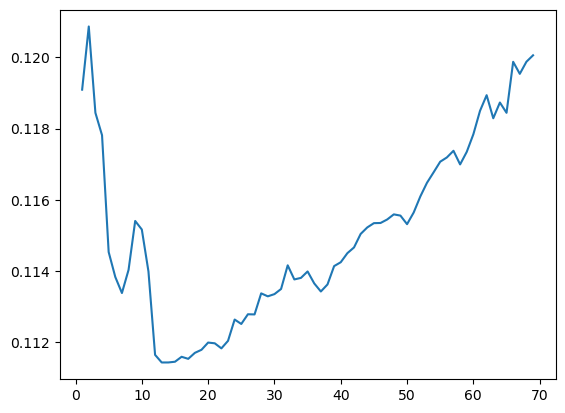

In [6]:
plt.plot(np.arange(max_num_comps)+1, rmse_fpqr_li)

In [7]:
comp_min_fpqr = np.argmin(rmse_fpqr_li)+1
comp_min_fpqr

13

In [9]:
with open('rmse_fpqr_li_5.pkl', 'wb') as file:
    pickle.dump(rmse_fpqr_li, file)

## Selection based on quantile error $EQ_{0.5}$

In [6]:
start_time = time.time()
max_num_comps = rank_X
qe_fpqr_li = []
for k in range(max_num_comps):
    fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=k+1, metric='li')  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store QE values
    qe_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        fpqr_li.fit(X_train, Y_train)
        predicted_values = fpqr_li.predict(X_test)
    
        # Calculate squared differences and QE for this fold
        qe = _quantile_function(Y_test, predicted_values, 0.5)
        qe_scores.append(qe)
    qe_k = np.mean(qe_scores)
    qe_fpqr_li.append(qe_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 50449.525033950806 seconds


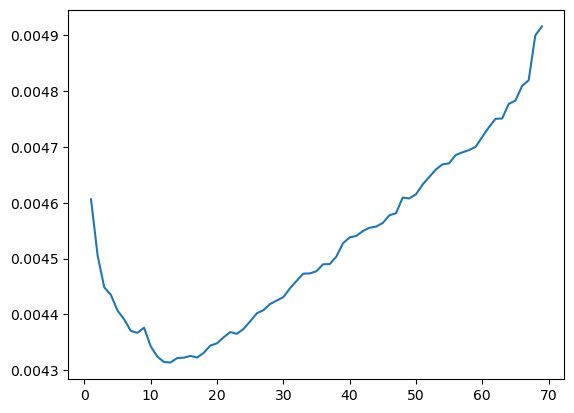

In [7]:
plt.plot(np.arange(max_num_comps)+1, qe_fpqr_li)

In [8]:
comp_min_fpqr = np.argmin(qe_fpqr_li)+1
comp_min_fpqr

13

In [9]:
with open('qe_fpqr_li_5.pkl', 'wb') as file:
    pickle.dump(qe_fpqr_li, file)

### Train the model

In [6]:
fpqr_li_5 = fpqr.FPQRegression(quantile=0.5, n_components=13, metric='li')
fpqr_li_5.fit(df_x_train, df_y_train)

In [7]:
pd.DataFrame(fpqr_li_5.x_rotations_)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.011222,-0.007534,-0.003484,-0.009686,0.030932,0.055670,0.042873,-0.058180,0.087848,-0.124318,0.112419,0.022544,0.067908
1,0.098149,-0.210468,0.543981,-0.218999,-0.013843,0.043203,0.109693,0.360718,0.236708,0.027512,-0.083268,0.228786,0.306648
2,-0.012738,0.055997,-0.076887,0.063847,-0.087640,-0.155360,-0.120088,0.023312,-0.125364,0.103927,-0.056186,-0.023904,0.005597
3,0.114366,-0.029378,0.044180,-0.100704,0.185316,0.075503,0.093410,-0.083805,-0.045084,-0.098866,0.147361,0.076969,0.003185
4,0.103136,-0.046281,0.085071,-0.139504,0.238106,0.155181,0.127346,-0.052750,0.008617,-0.152325,0.218746,0.142745,-0.007319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.229933,-0.330004,0.245875,-0.113343,0.105657,-0.134190,-0.241010,0.086846,0.261607,0.199129,-0.237484,-0.075020,-0.361061
65,-0.084678,-0.141264,0.177931,0.078889,-0.057702,0.178903,0.145418,0.148268,0.049931,0.237178,0.167142,0.187631,-0.059467
66,-0.162308,0.064389,-0.402084,0.103524,0.272509,0.326938,0.102606,0.178650,0.138061,-0.075150,-0.038094,0.082628,-0.070195
67,0.090671,-0.101922,0.106905,-0.107113,0.189323,0.194543,0.095226,-0.175874,0.142541,-0.201326,0.356628,0.139112,0.047049


In [19]:
number_of_variables = 15

# Get the indices of the 20 largest entries, ordered by decreasing entry value
largest_indices_r1 = np.argsort(fpqr_li_5.x_rotations_[:,0])[::-1][:number_of_variables]
largest_indices_r2 = np.argsort(fpqr_li_5.x_rotations_[:,1])[::-1][:number_of_variables]
largest_indices_r3 = np.argsort(fpqr_li_5.x_rotations_[:,2])[::-1][:number_of_variables]

In [20]:
print(largest_indices_r1)
print(largest_indices_r2)
print(largest_indices_r3)

[40 16 24 41 64 68 42 46 11 12 17 34 18  3 15]
[25 56 35 39 29 60 27 59 47 33 28 54 38 62 63]
[ 1 68 64 46 65 37 55  9 47 33 67  4 57 41 44]


In [21]:
largest_indices = [largest_indices_r1, largest_indices_r2, largest_indices_r3]

In [22]:
intersection = np.intersect1d(largest_indices_r1, largest_indices_r2)
intersection = np.intersect1d(intersection, largest_indices_r3)

In [23]:
intersection

array([], dtype=int64)

In [24]:
df_x_global = pd.read_csv('C:/Users/jorge/OneDrive/Documentos/Máster UC3M/TFM/X_global.csv')

In [25]:
selected_column_names = df_x_global.columns[intersection]
selected_column_names

Index([], dtype='object')

#### Plot of R weights by component

In [26]:
selected_column_names_T1 = df_x_global.columns[largest_indices_r1]
selected_R_weights_T1 = fpqr_li_5.x_rotations_[largest_indices_r1,0]

selected_column_names_T2 = df_x_global.columns[largest_indices_r2]
selected_R_weights_T2 = fpqr_li_5.x_rotations_[largest_indices_r2,1]

selected_column_names_T3 = df_x_global.columns[largest_indices_r3]
selected_R_weights_T3 = fpqr_li_5.x_rotations_[largest_indices_r3,2]

In [27]:
intersection12 = pd.Index(np.intersect1d(largest_indices_r1, largest_indices_r2))
intersection13 = np.intersect1d(largest_indices_r1, largest_indices_r3)
intersection23 = np.intersect1d(largest_indices_r2, largest_indices_r3)
intersection123 = np.intersect1d(intersection12, largest_indices_r3)
print(df_x_global.columns[intersection12])
print(df_x_global.columns[intersection13])
print(df_x_global.columns[intersection23])
print(df_x_global.columns[intersection123])

Index([], dtype='object')
Index(['ocf_lct', 'debt_assets', 'staff_sale', 'DIVYIELD'], dtype='object')
Index(['invt_act', 'debt_capital'], dtype='object')
Index([], dtype='object')


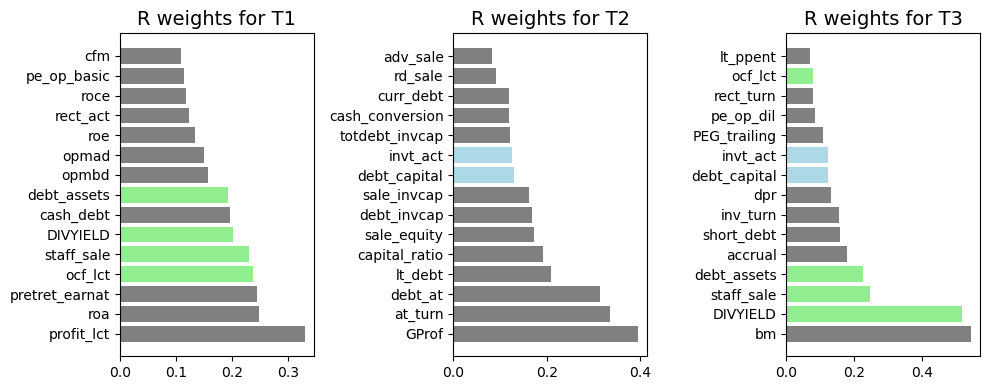

In [28]:
# Create a list of colors, replacing the default color for specific bars

indices_to_color_T1_intersect13 = [selected_column_names_T1.get_loc('ocf_lct'), selected_column_names_T1.get_loc('debt_assets'),
                                  selected_column_names_T1.get_loc('staff_sale'), selected_column_names_T1.get_loc('DIVYIELD')]
indices_to_color_T3_intersect13 = [selected_column_names_T3.get_loc('ocf_lct'), selected_column_names_T3.get_loc('debt_assets'),
                                  selected_column_names_T3.get_loc('staff_sale'), selected_column_names_T3.get_loc('DIVYIELD')]

indices_to_color_T2_intersect23 = [selected_column_names_T2.get_loc('invt_act'), selected_column_names_T2.get_loc('debt_capital')]
indices_to_color_T3_intersect23 = [selected_column_names_T3.get_loc('invt_act'), selected_column_names_T3.get_loc('debt_capital')]


bar_colors_T1 = ['gray'] * len(selected_column_names_T1)
for index in indices_to_color_T1_intersect13:
    bar_colors_T1[index] = 'lightgreen'

bar_colors_T2 = ['gray'] * len(selected_column_names_T2)
for index in indices_to_color_T2_intersect23:
    bar_colors_T2[index] = 'lightblue'

bar_colors_T3 = ['gray'] * len(selected_column_names_T3)
for index in indices_to_color_T3_intersect13:
    bar_colors_T3[index] = 'lightgreen'
for index in indices_to_color_T3_intersect23:
    bar_colors_T3[index] = 'lightblue'

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].barh(selected_column_names_T1, selected_R_weights_T1, color=bar_colors_T1)
axes[0].set_title("R weights for T1", fontsize=14)

axes[1].barh(selected_column_names_T2, selected_R_weights_T2, color=bar_colors_T2)
axes[1].set_title("R weights for T2", fontsize=14)

axes[2].barh(selected_column_names_T3, selected_R_weights_T3, color=bar_colors_T3)
axes[2].set_title("R weights for T3", fontsize=14)

plt.tight_layout()
plt.show()

#### Plot R weights by component considering positive and negative values of higher module

In [29]:
number_of_variables = 15

# Get the indices of the 20 largest entries, ordered by decreasing entry value
largest_abs_indices_r1 = np.argsort(abs(fpqr_li_5.x_rotations_[:,0]))[::-1][:number_of_variables]
largest_abs_indices_r2 = np.argsort(abs(fpqr_li_5.x_rotations_[:,1]))[::-1][:number_of_variables]
largest_abs_indices_r3 = np.argsort(abs(fpqr_li_5.x_rotations_[:,2]))[::-1][:number_of_variables]

In [30]:
print(largest_abs_indices_r1)
print(largest_abs_indices_r2)
print(largest_abs_indices_r3)

[40 38 16 24 41 64 68 42 46 66 11 12 25 56 37]
[25 68 56 64 35  1 39 29 40 60 27 59 11  7 12]
[ 1 68 66 25 16 64 46 39 65 24  5 37  7 55 56]


In [32]:
selected_column_names_abs_T1 = df_x_global.columns[largest_abs_indices_r1]
selected_R_weights_abs_T1 = fpqr_li_5.x_rotations_[largest_abs_indices_r1,0]

selected_column_names_abs_T2 = df_x_global.columns[largest_abs_indices_r2]
selected_R_weights_abs_T2 = fpqr_li_5.x_rotations_[largest_abs_indices_r2,1]

selected_column_names_abs_T3 = df_x_global.columns[largest_abs_indices_r3]
selected_R_weights_abs_T3 = fpqr_li_5.x_rotations_[largest_abs_indices_r3,2]

In [33]:
intersection12_abs = np.intersect1d(largest_abs_indices_r1, largest_abs_indices_r2)
intersection13_abs = np.intersect1d(largest_abs_indices_r1, largest_abs_indices_r3)
intersection23_abs = np.intersect1d(largest_abs_indices_r2, largest_abs_indices_r3)
intersection123_abs = np.intersect1d(intersection12_abs, largest_abs_indices_r3)
print(df_x_global.columns[intersection12_abs])
print(df_x_global.columns[intersection13_abs])
print(df_x_global.columns[intersection23_abs])
print(df_x_global.columns[intersection123_abs])

Index(['opmbd', 'opmad', 'GProf', 'profit_lct', 'at_turn', 'staff_sale',
       'DIVYIELD'],
      dtype='object')
Index(['roa', 'pretret_earnat', 'GProf', 'short_debt', 'debt_assets',
       'at_turn', 'staff_sale', 'ptb', 'DIVYIELD'],
      dtype='object')
Index(['bm', 'ps', 'GProf', 'lt_debt', 'at_turn', 'staff_sale', 'DIVYIELD'], dtype='object')
Index(['GProf', 'at_turn', 'staff_sale', 'DIVYIELD'], dtype='object')


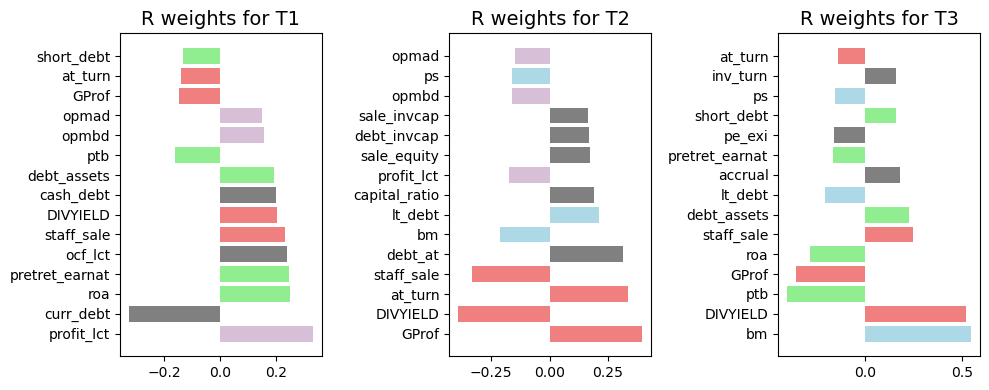

In [36]:
# Create a list of colors, replacing the default color for specific bars
indices_to_color_T1_intersect12 = [selected_column_names_abs_T1.get_loc('opmbd'), selected_column_names_abs_T1.get_loc('opmad'),
                                   selected_column_names_abs_T1.get_loc('GProf'), selected_column_names_abs_T1.get_loc('profit_lct'),
                                   selected_column_names_abs_T1.get_loc('at_turn'), selected_column_names_abs_T1.get_loc('staff_sale'),
                                   selected_column_names_abs_T1.get_loc('DIVYIELD')]
indices_to_color_T2_intersect12 = [selected_column_names_abs_T2.get_loc('opmbd'), selected_column_names_abs_T2.get_loc('opmad'),
                                   selected_column_names_abs_T2.get_loc('GProf'), selected_column_names_abs_T2.get_loc('profit_lct'),
                                   selected_column_names_abs_T2.get_loc('at_turn'), selected_column_names_abs_T2.get_loc('staff_sale'),
                                   selected_column_names_abs_T2.get_loc('DIVYIELD')]

indices_to_color_T1_intersect13 = [selected_column_names_abs_T1.get_loc('roa'), selected_column_names_abs_T1.get_loc('pretret_earnat'),
                                   selected_column_names_abs_T1.get_loc('GProf'), selected_column_names_abs_T1.get_loc('short_debt'),
                                   selected_column_names_abs_T1.get_loc('debt_assets'), selected_column_names_abs_T1.get_loc('at_turn'),
                                   selected_column_names_abs_T1.get_loc('staff_sale'), selected_column_names_abs_T1.get_loc('ptb'),
                                   selected_column_names_abs_T1.get_loc('DIVYIELD')]
indices_to_color_T3_intersect13 = [selected_column_names_abs_T3.get_loc('roa'), selected_column_names_abs_T3.get_loc('pretret_earnat'),
                                   selected_column_names_abs_T3.get_loc('GProf'), selected_column_names_abs_T3.get_loc('short_debt'),
                                   selected_column_names_abs_T3.get_loc('debt_assets'), selected_column_names_abs_T3.get_loc('at_turn'),
                                   selected_column_names_abs_T3.get_loc('staff_sale'), selected_column_names_abs_T3.get_loc('ptb'),
                                   selected_column_names_abs_T3.get_loc('DIVYIELD')]

indices_to_color_T2_intersect23 = [selected_column_names_abs_T2.get_loc('bm'), selected_column_names_abs_T2.get_loc('ps'),
                                   selected_column_names_abs_T2.get_loc('GProf'), selected_column_names_abs_T2.get_loc('lt_debt'),
                                   selected_column_names_abs_T2.get_loc('at_turn'), selected_column_names_abs_T2.get_loc('staff_sale'),
                                   selected_column_names_abs_T2.get_loc('DIVYIELD')]
indices_to_color_T3_intersect23 = [selected_column_names_abs_T3.get_loc('bm'), selected_column_names_abs_T3.get_loc('ps'),
                                   selected_column_names_abs_T3.get_loc('GProf'), selected_column_names_abs_T3.get_loc('lt_debt'),
                                   selected_column_names_abs_T3.get_loc('at_turn'), selected_column_names_abs_T3.get_loc('staff_sale'),
                                   selected_column_names_abs_T3.get_loc('DIVYIELD')]

indices_to_color_T1_intersect123 = [selected_column_names_abs_T1.get_loc('GProf'),selected_column_names_abs_T1.get_loc('at_turn'),
                                    selected_column_names_abs_T1.get_loc('staff_sale'),selected_column_names_abs_T1.get_loc('DIVYIELD')]
indices_to_color_T2_intersect123 = [selected_column_names_abs_T2.get_loc('GProf'),selected_column_names_abs_T2.get_loc('at_turn'),
                                    selected_column_names_abs_T2.get_loc('staff_sale'),selected_column_names_abs_T2.get_loc('DIVYIELD')]
indices_to_color_T3_intersect123 = [selected_column_names_abs_T3.get_loc('GProf'),selected_column_names_abs_T3.get_loc('at_turn'),
                                    selected_column_names_abs_T3.get_loc('staff_sale'),selected_column_names_abs_T3.get_loc('DIVYIELD')]

bar_colors_T1 = ['gray'] * len(selected_column_names_abs_T1)
for index in indices_to_color_T1_intersect12:
    bar_colors_T1[index] = 'thistle'
for index in indices_to_color_T1_intersect13:
    bar_colors_T1[index] = 'lightgreen'
for index in indices_to_color_T1_intersect123:
    bar_colors_T1[index] = 'lightcoral'

bar_colors_T2 = ['gray'] * len(selected_column_names_abs_T2)
for index in indices_to_color_T2_intersect12:
    bar_colors_T2[index] = 'thistle'
for index in indices_to_color_T2_intersect23:
    bar_colors_T2[index] = 'lightblue'
for index in indices_to_color_T2_intersect123:
    bar_colors_T2[index] = 'lightcoral'
    
bar_colors_T3 = ['gray'] * len(selected_column_names_abs_T3)
for index in indices_to_color_T3_intersect13:
    bar_colors_T3[index] = 'lightgreen'
for index in indices_to_color_T3_intersect23:
    bar_colors_T3[index] = 'lightblue'
for index in indices_to_color_T3_intersect123:
    bar_colors_T3[index] = 'lightcoral'
    
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].barh(selected_column_names_abs_T1, selected_R_weights_abs_T1, color=bar_colors_T1)
axes[0].set_title("R weights for T1", fontsize=14)

axes[1].barh(selected_column_names_abs_T2, selected_R_weights_abs_T2, color=bar_colors_T2)
axes[1].set_title("R weights for T2", fontsize=14)

axes[2].barh(selected_column_names_abs_T3, selected_R_weights_abs_T3, color=bar_colors_T3)
axes[2].set_title("R weights for T3", fontsize=14)

plt.tight_layout()
plt.show()

In [40]:
selected_column_names_abs_T3

Index(['bm', 'DIVYIELD', 'ptb', 'GProf', 'roa', 'staff_sale', 'debt_assets',
       'lt_debt', 'accrual', 'pretret_earnat', 'pe_exi', 'short_debt', 'ps',
       'inv_turn', 'at_turn'],
      dtype='object')

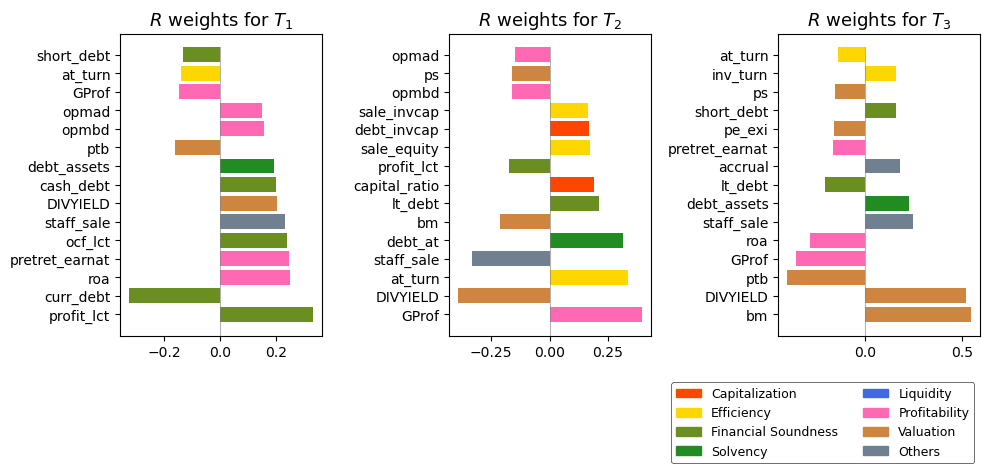

In [45]:
# Create a list of colors, replacing the default color for specific bars
indices_to_color_T1_finsound = [selected_column_names_abs_T1.get_loc('short_debt'), selected_column_names_abs_T1.get_loc('cash_debt'),
                                selected_column_names_abs_T1.get_loc('ocf_lct'), selected_column_names_abs_T1.get_loc('curr_debt'),
                                selected_column_names_abs_T1.get_loc('profit_lct')]
indices_to_color_T1_solvency = [selected_column_names_abs_T1.get_loc('debt_assets')]
indices_to_color_T1_others = [selected_column_names_abs_T1.get_loc('staff_sale')]
indices_to_color_T1_valuation = [selected_column_names_abs_T1.get_loc('ptb'), selected_column_names_abs_T1.get_loc('DIVYIELD')]
indices_to_color_T1_profitability = [selected_column_names_abs_T1.get_loc('GProf'), selected_column_names_abs_T1.get_loc('opmad'),
                                     selected_column_names_abs_T1.get_loc('opmbd'), selected_column_names_abs_T1.get_loc('pretret_earnat'),
                                     selected_column_names_abs_T1.get_loc('roa')]
indices_to_color_T1_efficiency = [selected_column_names_abs_T1.get_loc('at_turn')]

indices_to_color_T2_finsound = [selected_column_names_abs_T2.get_loc('profit_lct'), selected_column_names_abs_T2.get_loc('lt_debt')]
indices_to_color_T2_solvency = [selected_column_names_abs_T2.get_loc('debt_at')]
indices_to_color_T2_others = [selected_column_names_abs_T2.get_loc('staff_sale')]
indices_to_color_T2_valuation = [selected_column_names_abs_T2.get_loc('bm'), selected_column_names_abs_T2.get_loc('ps'),
                                 selected_column_names_abs_T2.get_loc('DIVYIELD')]
indices_to_color_T2_profitability = [selected_column_names_abs_T2.get_loc('opmad'),selected_column_names_abs_T2.get_loc('opmbd'),
                                     selected_column_names_abs_T2.get_loc('GProf')]
indices_to_color_T2_capitalization = [selected_column_names_abs_T2.get_loc('debt_invcap'), selected_column_names_abs_T2.get_loc('capital_ratio')]
indices_to_color_T2_efficiency = [selected_column_names_abs_T2.get_loc('sale_equity'), selected_column_names_abs_T2.get_loc('at_turn'),
                                  selected_column_names_abs_T2.get_loc('sale_invcap')]


indices_to_color_T3_finsound = [selected_column_names_abs_T3.get_loc('short_debt'), selected_column_names_abs_T3.get_loc('lt_debt')]
indices_to_color_T3_solvency = [selected_column_names_abs_T3.get_loc('debt_assets')]
indices_to_color_T3_others = [selected_column_names_abs_T3.get_loc('accrual'), selected_column_names_abs_T3.get_loc('staff_sale')]
indices_to_color_T3_valuation = [selected_column_names_abs_T3.get_loc('pe_exi'), selected_column_names_abs_T3.get_loc('ps'),
                                selected_column_names_abs_T3.get_loc('ptb'), selected_column_names_abs_T3.get_loc('bm'),
                                selected_column_names_abs_T3.get_loc('DIVYIELD')]
indices_to_color_T3_profitability = [selected_column_names_abs_T3.get_loc('pretret_earnat'), selected_column_names_abs_T3.get_loc('roa'),
                                     selected_column_names_abs_T3.get_loc('GProf')]
indices_to_color_T3_efficiency = [selected_column_names_abs_T3.get_loc('at_turn'), selected_column_names_abs_T3.get_loc('inv_turn')]

bar_colors_T1 = ['gray'] * len(selected_column_names_abs_T1)
for index in indices_to_color_T1_finsound:
    bar_colors_T1[index] = 'olivedrab'
for index in indices_to_color_T1_solvency:
    bar_colors_T1[index] = 'forestgreen'
for index in indices_to_color_T1_others:
    bar_colors_T1[index] = 'slategrey'
for index in indices_to_color_T1_valuation:
    bar_colors_T1[index] = 'peru'
for index in indices_to_color_T1_profitability:
    bar_colors_T1[index] = 'hotpink'
for index in indices_to_color_T1_efficiency:
    bar_colors_T1[index] = 'gold'

bar_colors_T2 = ['gray'] * len(selected_column_names_abs_T2)
for index in indices_to_color_T2_finsound:
    bar_colors_T2[index] = 'olivedrab'
for index in indices_to_color_T2_solvency:
    bar_colors_T2[index] = 'forestgreen'
for index in indices_to_color_T2_others:
    bar_colors_T2[index] = 'slategrey'
for index in indices_to_color_T2_valuation:
    bar_colors_T2[index] = 'peru'
for index in indices_to_color_T2_profitability:
    bar_colors_T2[index] = 'hotpink'
for index in indices_to_color_T2_capitalization:
    bar_colors_T2[index] = 'orangered'
for index in indices_to_color_T2_efficiency:
    bar_colors_T2[index] = 'gold'
    
bar_colors_T3 = ['gray'] * len(selected_column_names_abs_T3)
for index in indices_to_color_T3_finsound:
    bar_colors_T3[index] = 'olivedrab'
for index in indices_to_color_T3_solvency:
    bar_colors_T3[index] = 'forestgreen'
for index in indices_to_color_T3_others:
    bar_colors_T3[index] = 'slategrey'
for index in indices_to_color_T3_valuation:
    bar_colors_T3[index] = 'peru'
for index in indices_to_color_T3_profitability:
    bar_colors_T3[index] = 'hotpink'
for index in indices_to_color_T3_efficiency:
    bar_colors_T3[index] = 'gold'
    
fig, axes = plt.subplots(1, 3, figsize=(10, 3.8))

axes[0].barh(selected_column_names_abs_T1, selected_R_weights_abs_T1, color=bar_colors_T1)
axes[0].set_title("$R$ weights for $T_1$", fontsize=13)
axes[0].axvline(x=0, color='grey', linewidth=0.8, ymin=0.0, ymax=0.955, alpha=0.6)

axes[1].barh(selected_column_names_abs_T2, selected_R_weights_abs_T2, color=bar_colors_T2)
axes[1].set_title("$R$ weights for $T_2$", fontsize=13)
axes[1].axvline(x=0, color='grey', linewidth=0.8, ymin=0.0, ymax=0.955, alpha=0.6)

axes[2].barh(selected_column_names_abs_T3, selected_R_weights_abs_T3, color=bar_colors_T3)
axes[2].set_title("$R$ weights for $T_3$", fontsize=13)
axes[2].axvline(x=0, color='grey', linewidth=0.8, ymin=0.0, ymax=0.955, alpha=0.6)

legend_patches = [
    mpatches.Patch(color='orangered', label='Capitalization'),
    mpatches.Patch(color='gold', label='Efficiency'),
    mpatches.Patch(color='olivedrab', label='Financial Soundness'),
    mpatches.Patch(color='forestgreen', label='Solvency'),
    mpatches.Patch(color='royalblue', label='Liquidity'),
    mpatches.Patch(color='hotpink', label='Profitability'),
    mpatches.Patch(color='peru', label='Valuation'),
    mpatches.Patch(color='slategrey', label='Others')
]

# Add the legend below the plots with smaller font size
legend = fig.legend(handles=legend_patches, loc='lower left', bbox_to_anchor=(0.67, -0.25), ncol=2, prop={'size': 9})

# Adjust the legend border to make it smaller
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.show()